# SVD Baseline Approximation

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
df = pd.read_csv('..\Data\Input\Phx_Rating.csv')
train, test = train_test_split(df, test_size = 0.2)
print len(train)
print len(test)

150819
37705


#### Creating dictionaries of restaurants and users

In [2]:
restr_dict = {}
user_dict = {}
rest_cnt = 0
user_cnt = 0
for index, row in train.iterrows():
    if row[0] not in user_dict:        
        user_dict[row[0]] = user_cnt
        user_cnt = user_cnt + 1
    if row[2] not in restr_dict:        
        restr_dict[row[2]] = rest_cnt
        rest_cnt = rest_cnt + 1

In [3]:
print user_cnt
print rest_cnt

56677
2915


#### Creating a numpy matrix

In [4]:
users_restr = np.zeros((int(len(user_dict)),int(len(restr_dict))))
print users_restr.shape

(56677L, 2915L)


In [5]:
for index, row in train.iterrows():
    try:
        users_restr[int(user_dict[row[0]]) , int(restr_dict[row[2]])] = row[3]
    except Exception as e:
        print e
        continue

#### Getting avg stars for each restaurant to make data dense

In [6]:
phx_business = open('..\Data\Input\Restaurants_Phoenix.csv')
phx_csv = csv.reader(phx_business)
phx_data = list(phx_csv)
r_avg_dict = {}
header = True
i = 1
while i < len(phx_data):    
    avg_rat = phx_data[i][61]    
    b_id = phx_data[i][15]    
    r_avg_dict[b_id] = float(avg_rat)
    i = i + 1

In [7]:
print len(r_avg_dict)

2925


#### Replacing every 0 entry with restaurant average

In [8]:
for key in restr_dict:
    i = 0
    while i < user_cnt:
        if users_restr[i][restr_dict[key]] == 0:
            users_restr[i][restr_dict[key]] = r_avg_dict[key]
        i = i + 1

#### Finding avg user rating

In [9]:
u_avg_rat = {}
# dict in the form of ['userid',(no. of reviews by the user, sum of all ratings)]

for index, row in train.iterrows(): 
    if row[0] not in u_avg_rat:
        u_avg_rat[row[0]] = (1 , int(row[3]))
    else:
        tup = u_avg_rat[row[0]]
        new_tup = (tup[0] + 1 , tup[1] + int(row[3]))
        u_avg_rat[row[0]] = new_tup

In [10]:
print "Total no. of unique users = %d" % len(u_avg_rat)
#print u_avg_rat['t95D1tnWvAOy2sxXnI3GUA']

Total no. of unique users = 56677


#### Normalizing each element in the matrix by subtracting from avg user rating

In [11]:
for key in user_dict:
    i = 0
    pos = user_dict[key]
    tup = u_avg_rat[key]
    user_avg_rating = tup[1] / tup[0]
    while i < rest_cnt:
        users_restr[pos][i] -= user_avg_rating            
        i = i + 1

#### Finally calculating the SVD

In [12]:
U, s, V = np.linalg.svd(users_restr, full_matrices=False)

In [13]:
print U.shape
print s.shape
print V.shape

(56677L, 2915L)
(2915L,)
(2915L, 2915L)


In [14]:
S = np.diag(s)
print S.shape

(2915L, 2915L)


### Reducing to top k dimensions for a list of k values

In [15]:
kvals = list(range(2,21))
kvals.append(25)
kvals.append(50)
kvals.append(100)

#### Predicting and calculating error

In [16]:
all_rmse = []
all_mae = []
for DIM in kvals:
    U1 = U[:, :DIM]
    S1 = S[:DIM, :DIM]
    V1 = V.T[:, :DIM].T
    S12 = np.sqrt(S1)
    A1 = np.dot(U1,S12)
    A2 = np.dot(S12,V1)
    meancnt = 0
    mae_par = 0
    rmse_par = 0
    for index, row in test.iterrows(): 
        if row[0] in user_dict and row[2] in restr_dict:
            meancnt += 1
            actual = float(row[3])
            pred = np.dot(A1[user_dict[row[0]],:] , A2[:,restr_dict[row[2]]])
            tup = u_avg_rat[row[0]]
            tup_avg = tup[1] / tup[0]
            pred += tup_avg
            rmse_par += (pred - actual) ** 2
            mae_par += abs(pred - actual)
    all_rmse.append((rmse_par / meancnt) ** 0.5)
    all_mae.append(mae_par / meancnt)

#### Printing out the errors, we get a min RMSE ~ 1.137153 and min MAE ~ 0.887598 for k = 2, but this varies very slighly in different executions for different training and test sets

In [17]:
print all_rmse
print all_mae
print min(all_rmse)
print min(all_mae)

[1.13734721071971, 1.1371531267082275, 1.137536172720097, 1.1374105002400545, 1.1373797475187883, 1.1376014285197098, 1.1374572558257414, 1.1373358438153176, 1.137229848733692, 1.1373127672712628, 1.1375047274775532, 1.1375975358069079, 1.1376604290794305, 1.1378787305466453, 1.1377394048516249, 1.137793780817637, 1.1378112087202208, 1.1380886770970926, 1.1381295377073337, 1.1381269476228995, 1.138257780563511, 1.1398012541675957]
[0.8878277721492579, 0.88759758966200153, 0.88770373875300435, 0.88769523623711755, 0.88770045844796519, 0.88786355695447561, 0.8878205249044484, 0.88763121014548718, 0.88766547185046929, 0.88766527919840044, 0.88779532909215653, 0.88780313544996858, 0.88775470760332098, 0.88784353676848027, 0.88797024462408736, 0.88808920568773408, 0.88812505189593816, 0.88840730338189211, 0.88845578416607573, 0.88846411549236826, 0.88821214882919963, 0.887848417182029]
1.13715312671
0.887597589662


#### Plotting the k values v/s the MAE and RMSE. k = [ 2-21, 25, 50, 100]

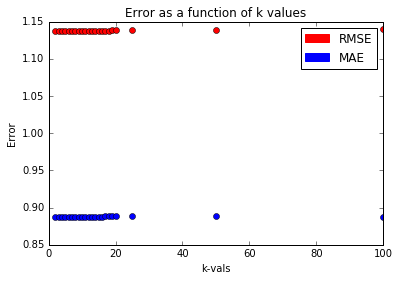

In [18]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.plot(kvals , all_rmse, 'ro', kvals , all_mae, 'bo')
plt.xlabel('k-vals')
plt.ylabel('Error')
red_patch = mpatches.Patch(color='red', label='RMSE')
blue_patch = mpatches.Patch(color='blue', label='MAE')
plt.legend(handles=[red_patch,blue_patch])
plt.title('Error as a function of k values')
plt.show()